# 1D Soil Water Balance — Demo

This demo illustrates the **`pyAPES.soil`** package: solving the soil water balance without a heat model.

### Modules used
- **`pyAPES.soil.soil.Soil_1D`** — top-level object combining the water and heat sub-models
- **`pyAPES.soil.water.Water_1D`** — Richards-equation-based water balance
- Heat model (`heat_model['solve'] = False`) — not solved; object is initialised but inactive

### Simulated soil column

Total depth **2 m**, three physically distinct layers:

| Layer | Depth | Description |
|-------|-------|-------------|
| Forest humus | 0–10 cm | Organic surface layer, high porosity, moderate hydraulic conductivity |
| Peat | 10–150 cm | Sphagnum-type peat, very high porosity and hydraulic conductivity |
| Clay | 150–200 cm | Mineral clay, low porosity, very low hydraulic conductivity |

> **Physical rationale:** Clay beneath peat is a common profile in Finnish peatlands and peatland margins.
> Glacial and post-glacial clay deposits are widespread, and peat has accumulated on top of them
> over millennia. The clay layer acts as a near-impermeable lower boundary, keeping the water table
> high — typical of mire environments.

### Simulation scenario
Rain event: 3 mm/h for the first 12 h, followed by drying over 3 days.

In [239]:
import sys
import os

# --- Path setup ---
# Option 1: use .env file (see Demo_soil_water_heat.ipynb for reference)
try:
    from dotenv import load_dotenv
    load_dotenv()
    pyAPES_main_folder = os.getenv('pyAPES_main_folder')
    if pyAPES_main_folder:
        sys.path.insert(0, pyAPES_main_folder)
except ImportError:
    pass

# Option 2: direct path (uncomment and set if .env is not configured)
# sys.path.insert(0, '/Path/to/pyAPES_main)

# Option 3: relative path (works when running from Examples/)
if not any('pyAPES_main' in p for p in sys.path):
    sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib.pyplot as plt

# pyAPES soil module
from pyAPES.soil.soil import Soil_1D
%matplotlib widget
%load_ext autoreload
%autoreload 2
print('Imports OK')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imports OK


## 1. Soil Profile Structure and Parameters

Define layer thicknesses, the computational grid, and the soil hydraulic properties.

`form_profile` (called inside `Soil_1D.__init__`) maps the per-zone parameters
defined at `zh` boundaries onto every computational node in `z`.

In [240]:
# ============================================================
# USER PARAMETERS — edit here
# ============================================================

# Layer depths [m]
humus_depth = 0.10   # thickness of forest humus layer [m]
peat_depth  = 1.40   # thickness of peat layer [m]
clay_depth  = 0.50   # thickness of clay layer [m]

total_depth = humus_depth + peat_depth + clay_depth   # = 2.0 m

# Grid resolution (layer thickness in each zone)
dz_h = 0.01   # [m] humus: 1 cm layers  -> n_humus = 10
dz_p = 0.05   # [m] peat:  5 cm layers  -> n_peat  = 28
dz_c = 0.05   # [m] clay:  5 cm layers  -> n_clay  = 10

# Initial condition
gwl_ini = -0.80   # initial groundwater level [m], negative = below surface

# Simulation settings
n_days   = 3        # total simulation length [days]
dt       = 1800.0   # time step [s] = 30 min

# Forcing
rain_rate  = 3e-3 / 3600.0    # [m/s] = 3 mm/h during rain event
rain_hours = 12.0              # [h]   duration of rain event
evap_rate  = 0.5e-3 / 86400.0 # [m/s] = 0.5 mm/day background evaporation (dry periods)

# ============================================================

# Build layer thickness array (dz) from user parameters
n_h = int(round(humus_depth / dz_h))
n_p = int(round(peat_depth  / dz_p))
n_c = int(round(clay_depth  / dz_c))
dz  = [dz_h]*n_h + [dz_p]*n_p + [dz_c]*n_c
Nz  = len(dz)

# Bottom boundaries of layers with different parametrization [m]
# soil surface = 0.0, depth negative downward
# form_profile uses these to assign parameters to each node
zh_humus = -humus_depth
zh_peat  = -(humus_depth + peat_depth)
zh_clay  = -(total_depth)          # = -2.0 m (bottom of profile)
zh = [zh_humus, zh_peat, zh_clay]

# Node centres [m]
dz_arr = np.array(dz)
z_nodes = dz_arr / 2.0 - np.cumsum(dz_arr)

print(f'Soil column: {total_depth:.1f} m deep, {Nz} computational nodes')
print(f'  Forest humus: {n_h} layers x {dz_h*100:.0f} cm  (0 … {humus_depth*100:.0f} cm)')
print(f'  Peat:         {n_p} layers x {dz_p*100:.0f} cm  ({humus_depth*100:.0f} … {(humus_depth+peat_depth)*100:.0f} cm)')
print(f'  Clay:         {n_c} layers x {dz_c*100:.0f} cm  ({(humus_depth+peat_depth)*100:.0f} … {total_depth*100:.0f} cm)')
print(f'zh (layer boundaries): {zh}')

Soil column: 2.0 m deep, 48 computational nodes
  Forest humus: 10 layers x 1 cm  (0 … 10 cm)
  Peat:         28 layers x 5 cm  (10 … 150 cm)
  Clay:         10 layers x 5 cm  (150 … 200 cm)
zh (layer boundaries): [-0.1, -1.5, -2.0]


### Hydraulic Properties — van Genuchten Parameters

Water retention is described by the van Genuchten–Mualem model:

$$\theta(h) = \theta_r + \frac{\theta_s - \theta_r}{\left(1 + |\alpha h|^n\right)^m}, \quad m = 1 - 1/n$$

where $h$ is the pressure head [cm], $\alpha$ [cm⁻¹] is the air-entry suction parameter, and
$n$ is the pore size distribution parameter.

Saturated hydraulic conductivity in the clay layer is roughly **10 000× lower** than in peat —
the key factor controlling water table dynamics in this profile.

In [241]:
# ============================================================
# SOIL PROPERTIES
# Order: [forest humus, peat, clay]
# ============================================================

soil_properties = {
    # van Genuchten water retention parameters
    # Sources:
    #   Humus/peat: Liu & Lennartz (2019), Launiainen et al. (2022)
    #   Clay: Schaap et al. (2001) Rosetta database, silty clay
    'pF': {
        'ThetaS': [0.75,  0.88,  0.52],   # [m3 m-3] saturated water content
        'ThetaR': [0.05,  0.05,  0.10],   # [m3 m-3] residual water content
        'alpha':  [0.020, 0.014, 0.004],   # [cm-1]   air-entry suction
        'n':      [1.40,  1.25,  1.15],    # [-]       pore size distribution
    },

    # Saturated hydraulic conductivity
    'saturated_conductivity_vertical':   [5e-5, 1e-4, 1e-8],   # [m s-1]
    'saturated_conductivity_horizontal': [5e-5, 1e-4, 1e-8],   # [m s-1]

    # Solid composition (fractions of SOLID volume, each row must sum to 1)
    'solid_composition': {
        'organic': [0.90, 1.00, 0.05],
        'sand':    [0.05, 0.00, 0.05],
        'silt':    [0.05, 0.00, 0.40],
        'clay':    [0.00, 0.00, 0.50],
    },

    # Solid heat capacity [J m-3 K-1]; None -> estimated from organic fraction
    'solid_heat_capacity': None,

    # Freezing curve parameter (required by Heat_1D even when not solved)
    'freezing_curve': [0.5, 0.3, 2.0],

    # Bedrock properties (required by form_profile; not activated for this profile)
    'bedrock': {
        'solid_heat_capacity': 2.16e6,    # [J m-3 K-1]
        'thermal_conductivity': 3.0,       # [W m-1 K-1]
    },
}

layer_names = ['Forest humus', 'Peat', 'Clay']

# Print summary table
print(fr'{"Layer":15s}  {"ThetaS":>7s}  {"ThetaR":>7s}  {"alpha":>8s}  {"n":>5s}  {"Ksat_v [m/s]":>14s}')
print('-' * 65)
for i, name in enumerate(layer_names):
    print(f'{name:15s}  '
          f'{soil_properties["pF"]["ThetaS"][i]:7.3f}  '
          f'{soil_properties["pF"]["ThetaR"][i]:7.3f}  '
          f'{soil_properties["pF"]["alpha"][i]:8.4f}  '
          f'{soil_properties["pF"]["n"][i]:5.2f}  '
          f'{soil_properties["saturated_conductivity_vertical"][i]:14.2e}')

Layer             ThetaS   ThetaR     alpha      n    Ksat_v [m/s]
-----------------------------------------------------------------
Forest humus       0.750    0.050    0.0200   1.40        5.00e-05
Peat               0.880    0.050    0.0140   1.25        1.00e-04
Clay               0.520    0.100    0.0040   1.15        1.00e-08


In [242]:
# ============================================================
# WATER MODEL SETTINGS
# ============================================================
water_model = {
    'solve': True,
    'type': 'Richards',               # Richards equation (alternative: 'Equilibrium')
    'pond_storage_max': 0.05,         # maximum surface ponding depth [m]

    'initial_condition': {
        'ground_water_level': gwl_ini,  # initial water table [m], negative = below surface
        'pond_storage': 0.0,
    },

    'lower_boundary': {
        'type': 'impermeable',          # impermeable lower boundary (clay layer)
        'value': None,
        # depth > total_depth: prevents bedrock properties being applied in form_profile
        'depth': -3.0,
    },

    'drainage_equation': {
        'type': None,                   # no lateral drainage in this demo
    },
}

# ============================================================
# HEAT MODEL SETTINGS  (not solved — solve=False)
# ============================================================
heat_model = {
    'solve': False,                     # heat equation NOT solved
    'initial_condition': {
        # Constant temperature > 0 °C -> no freezing, Wice = 0
        'temperature': 10.0,            # [degC]
    },
    'lower_boundary': {
        'type': 'flux',
        'value': 0.0,
    },
}

# ============================================================
# ASSEMBLED PARAMETER DICT  ->  Soil_1D
# ============================================================
spara = {
    'grid': {
        'dz': dz,    # list of layer thicknesses [m]
        'zh': zh,    # list of bottom elevations of parameter zones [m]
    },
    'soil_properties': soil_properties,
    'water_model': water_model,
    'heat_model': heat_model,
}

print('Parameter dict assembled.')

Parameter dict assembled.


## 2. Model Initialisation

`Soil_1D(spara)` internally calls `form_profile`, which distributes the per-zone parameters
to node-level arrays. Both `Water_1D` and `Heat_1D` are initialised — only the water model is solved.

In [243]:
model = Soil_1D(spara)

# Convenience references
z      = model.grid['z']      # node centres [m], negative
dz_arr = model.grid['dz']     # layer thicknesses [m]
Nz     = model.Nlayers
storage_initial = np.sum(model.water.Wtot * dz_arr)# initial water storage [m], used later for computing change in storage

print(f'Model initialised: {Nz} computational nodes')
print(f'Depth range: {z[0]:.4f} … {z[-1]:.4f} m')
print(f'Initial water table: {model.water.gwl:.3f} m')
print(f'Heat model solved: {model.solve_heat}')
print(f'Water model solved: {model.solve_water}')
print(f'Water model type: {model.water.solution_type}')
print(f'Initial water storage: {storage_initial:.2f} mm')

Model initialised: 48 computational nodes
Depth range: -0.0050 … -1.9750 m
Initial water table: -0.800 m
Heat model solved: False
Water model solved: True
Water model type: RICHARDS EQUATION
Initial water storage: 1.51 mm


In [244]:
model.water.Wtot

array([0.56568453, 0.56739721, 0.56912688, 0.57087377, 0.57263811,
       0.57442012, 0.57622004, 0.5780381 , 0.57987453, 0.58172957,
       0.77759355, 0.78420772, 0.79105738, 0.79814861, 0.8054851 ,
       0.81306673, 0.82088764, 0.82893316, 0.83717515, 0.84556434,
       0.85401708, 0.86238977, 0.87041904, 0.87750957, 0.88      ,
       0.88      , 0.88      , 0.88      , 0.88      , 0.88      ,
       0.88      , 0.88      , 0.88      , 0.88      , 0.88      ,
       0.88      , 0.88      , 0.88      , 0.52      , 0.52      ,
       0.52      , 0.52      , 0.52      , 0.52      , 0.52      ,
       0.52      , 0.52      , 0.52      ])

In [245]:
model.water.Wtot

array([0.56568453, 0.56739721, 0.56912688, 0.57087377, 0.57263811,
       0.57442012, 0.57622004, 0.5780381 , 0.57987453, 0.58172957,
       0.77759355, 0.78420772, 0.79105738, 0.79814861, 0.8054851 ,
       0.81306673, 0.82088764, 0.82893316, 0.83717515, 0.84556434,
       0.85401708, 0.86238977, 0.87041904, 0.87750957, 0.88      ,
       0.88      , 0.88      , 0.88      , 0.88      , 0.88      ,
       0.88      , 0.88      , 0.88      , 0.88      , 0.88      ,
       0.88      , 0.88      , 0.88      , 0.52      , 0.52      ,
       0.52      , 0.52      , 0.52      , 0.52      , 0.52      ,
       0.52      , 0.52      , 0.52      ])

## 3. pF Curves — Water Retention per Layer

The pF curve shows volumetric water content ($\theta$) as a function of the log of the
matric suction: $\text{pF} = \log_{10}(|h|_{\text{cm}})$.

- **pF 2.0** ≈ field capacity ($h$ = −100 cm = −1 m)
- **pF 4.2** ≈ wilting point ($h$ = −15 000 cm = −150 m)

The peat layer has a much higher water storage capacity (high $\theta_s$), while water
in the clay is more tightly bound (low $\alpha$, low $n$).


Layer               θ_s    θ(pF2)   θ(pF4.2)    Ksat [m/s]
------------------------------------------------------------
Forest humus      0.750     0.534      0.120      5.00e-05
Peat              0.880     0.740      0.265      1.00e-04
Clay              0.520     0.504      0.325      1.00e-08


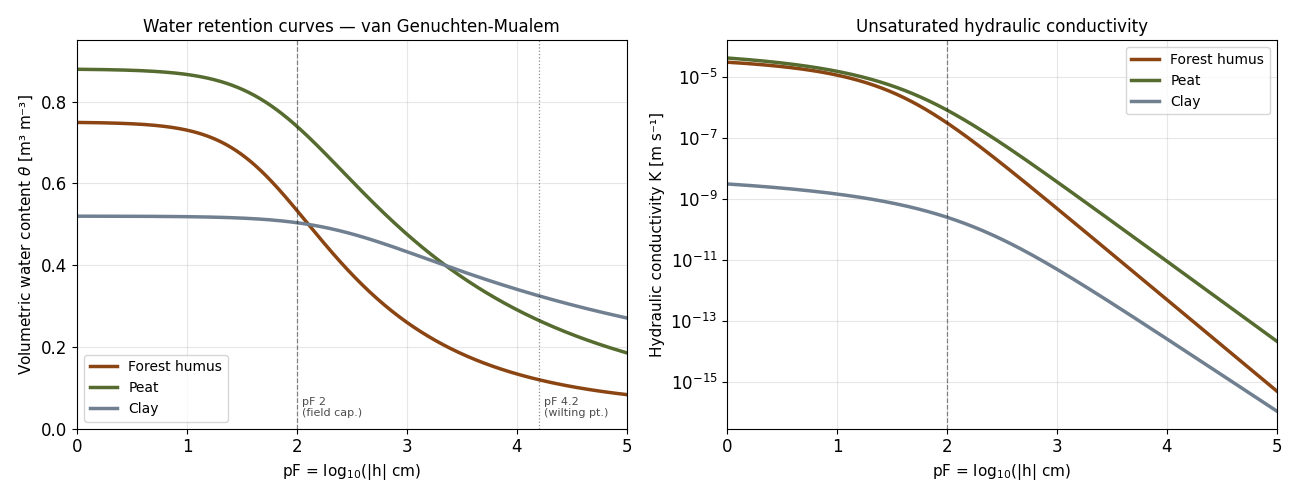

In [246]:
def vg_theta(ThetaS, ThetaR, alpha, n, psi_cm):
    """van Genuchten water retention. psi_cm: suction in cm (positive)."""
    m = 1.0 - 1.0 / n
    return ThetaR + (ThetaS - ThetaR) / (1.0 + np.abs(alpha * psi_cm)**n)**m

pF_range = np.linspace(0, 5, 600)
psi_cm   = 10.0**pF_range

layer_colors = ['#8B4513', '#556B2F', '#708090']   # humus, peat, clay
pF_params = soil_properties['pF']

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Left: water retention curves ---
ax = axes[0]
for i, (name, color) in enumerate(zip(layer_names, layer_colors)):
    theta = vg_theta(pF_params['ThetaS'][i], pF_params['ThetaR'][i],
                     pF_params['alpha'][i], pF_params['n'][i], psi_cm)
    ax.plot(pF_range, theta, color=color, lw=2.5, label=name)

ax.axvline(2.0, color='k', lw=0.9, ls='--', alpha=0.45, label='_')
ax.axvline(4.2, color='k', lw=0.9, ls=':',  alpha=0.45, label='_')
ax.text(2.05, 0.03, 'pF 2\n(field cap.)', fontsize=8, alpha=0.7)
ax.text(4.25, 0.03, 'pF 4.2\n(wilting pt.)', fontsize=8, alpha=0.7)
ax.set_xlabel('pF = log$_{10}$(|h| cm)', fontsize=11)
ax.set_ylabel('Volumetric water content $\\theta$ [m³ m⁻³]', fontsize=11)
ax.set_title('Water retention curves — van Genuchten-Mualem', fontsize=12)
ax.legend(fontsize=10)
ax.set_xlim(0, 5); ax.set_ylim(0, 0.95)
ax.grid(True, alpha=0.3)

# --- Right: hydraulic conductivity curves ---
ax = axes[1]
for i, (name, color) in enumerate(zip(layer_names, layer_colors)):
    ThetaS = pF_params['ThetaS'][i]; ThetaR = pF_params['ThetaR'][i]
    alpha  = pF_params['alpha'][i];  n_vg   = pF_params['n'][i]
    m = 1.0 - 1.0 / n_vg
    Ksat = soil_properties['saturated_conductivity_vertical'][i]

    # van Genuchten-Mualem relative conductivity
    Se = 1.0 / (1.0 + np.abs(alpha * psi_cm)**n_vg)**m
    Kr = Se**0.5 * (1.0 - (1.0 - Se**(1.0/m))**m)**2.0
    K  = Ksat * Kr
    K  = np.maximum(K, 1e-20)  # avoid log(0)
    ax.semilogy(pF_range, K, color=color, lw=2.5, label=name)

ax.axvline(2.0, color='k', lw=0.9, ls='--', alpha=0.45)
ax.set_xlabel('pF = log$_{10}$(|h| cm)', fontsize=11)
ax.set_ylabel('Hydraulic conductivity K [m s⁻¹]', fontsize=11)
ax.set_title('Unsaturated hydraulic conductivity', fontsize=12)
ax.legend(fontsize=10)
ax.set_xlim(0, 5)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
#plt.show()

# Summary table
print(f'\n{"Layer":15s}  {"θ_s":>6s}  {"θ(pF2)":>8s}  {"θ(pF4.2)":>9s}  {"Ksat [m/s]":>12s}')
print('-' * 60)
for i, name in enumerate(layer_names):
    fc = vg_theta(pF_params['ThetaS'][i], pF_params['ThetaR'][i],
                  pF_params['alpha'][i],  pF_params['n'][i], 100.0)
    wp = vg_theta(pF_params['ThetaS'][i], pF_params['ThetaR'][i],
                  pF_params['alpha'][i],  pF_params['n'][i], 15849.0)
    Ksat = soil_properties['saturated_conductivity_vertical'][i]
    print(f'{name:15s}  {pF_params["ThetaS"][i]:6.3f}  {fc:8.3f}  {wp:9.3f}  {Ksat:12.2e}')

## 4. Simulation — Rain Event

The time loop calls `model.run(dt, forcing)` at each time step.

**Boundary conditions:**
- Upper: rain 3 mm/h for the first 12 h → background evaporation 0.5 mm/day thereafter
- Lower: `impermeable` (clay layer prevents flow through the bottom)

**Forcing dict fields:**

| Field | Description | Unit |
|-------|-------------|------|
| `potential_infiltration` | Potential rainfall / infiltration | m s⁻¹ |
| `potential_evaporation` | Potential evaporation | m s⁻¹ |
| `pond_recharge` | Removal from surface pond | m s⁻¹ |
| `atmospheric_pressure_head` | Atmospheric water potential (limits evaporation) | m |
| `date` | Timestamp (for internal logger) | str |

The **Richards equation** uses adaptive sub-stepping: the internal `dto` shrinks automatically
when convergence is slow (e.g. at the onset of rain or near layer interfaces).

In [247]:
import datetime

t_final = n_days * 86400.0       # total simulation time [s]
n_steps = int(t_final / dt)      # number of outer time steps
t_rain  = rain_hours * 3600.0    # rain duration [s]

# Pre-allocate result arrays
SWC      = np.full((n_steps, Nz), np.nan)   # volumetric water content [m3 m-3]
h_prof   = np.full((n_steps, Nz), np.nan)   # water potential [m]
gwl_ts   = np.full(n_steps, np.nan)          # ground water level [m]
infil_ts = np.full(n_steps, np.nan)          # infiltration rate [m s-1]
drain_ts = np.full(n_steps, np.nan)          # drainage rate [m s-1]
roff_ts  = np.full(n_steps, np.nan)          # surface runoff [m s-1]
pond_ts  = np.full(n_steps, np.nan)          # pond storage [m]
mbe = np.full(n_steps,np.nan)                # mass balance error

print(f'Simulation: {n_days} days | {n_steps} time steps | dt = {dt/60:.0f} min')
print(f'Rain: {rain_rate*3600*1000:.1f} mm/h for {rain_hours:.0f} h  ({rain_rate*rain_hours*3600*1000:.0f} mm total)')
print('Running...')

t0 = datetime.datetime(2024, 6, 1)  # reference time for logger

for i in range(n_steps):
    t_current = i * dt
    t_date    = t0 + datetime.timedelta(seconds=t_current)

    # Switch between rain and evaporation phases
    if t_current < t_rain:
        rain = rain_rate
        evap = 0.0
    else:
        rain = 0.0
        evap = evap_rate

    forcing = {
        'potential_infiltration':    rain,
        'potential_evaporation':     evap,
        'pond_recharge':             0.0,
        'atmospheric_pressure_head': -100.0,  # [m] — limits evaporation
        'date':                      str(t_date),
        # 'temperature' used by heat.update_state() when solve_heat=False
        'temperature':               10.0,
    }

    fluxes, state = model.run(dt, forcing)

    # Store results
    SWC[i]      = state['volumetric_water_content']
    h_prof[i]   = state['water_potential']
    gwl_ts[i]   = state['ground_water_level']
    infil_ts[i] = fluxes.get('infiltration',   0.0)
    drain_ts[i] = fluxes.get('drainage',        0.0)
    roff_ts[i]  = fluxes.get('surface_runoff',  0.0)
    pond_ts[i]  = state['pond_storage']
    mbe[i] = fluxes['water_closure']

print('Done!')
t_h = np.arange(n_steps) * dt / 3600.0   # time axis [h]

Simulation: 3 days | 144 time steps | dt = 30 min
Rain: 3.0 mm/h for 12 h  (36 mm total)
Running...
Done!


## 5. Results

### 5a. Soil Profile Evolution Over Time

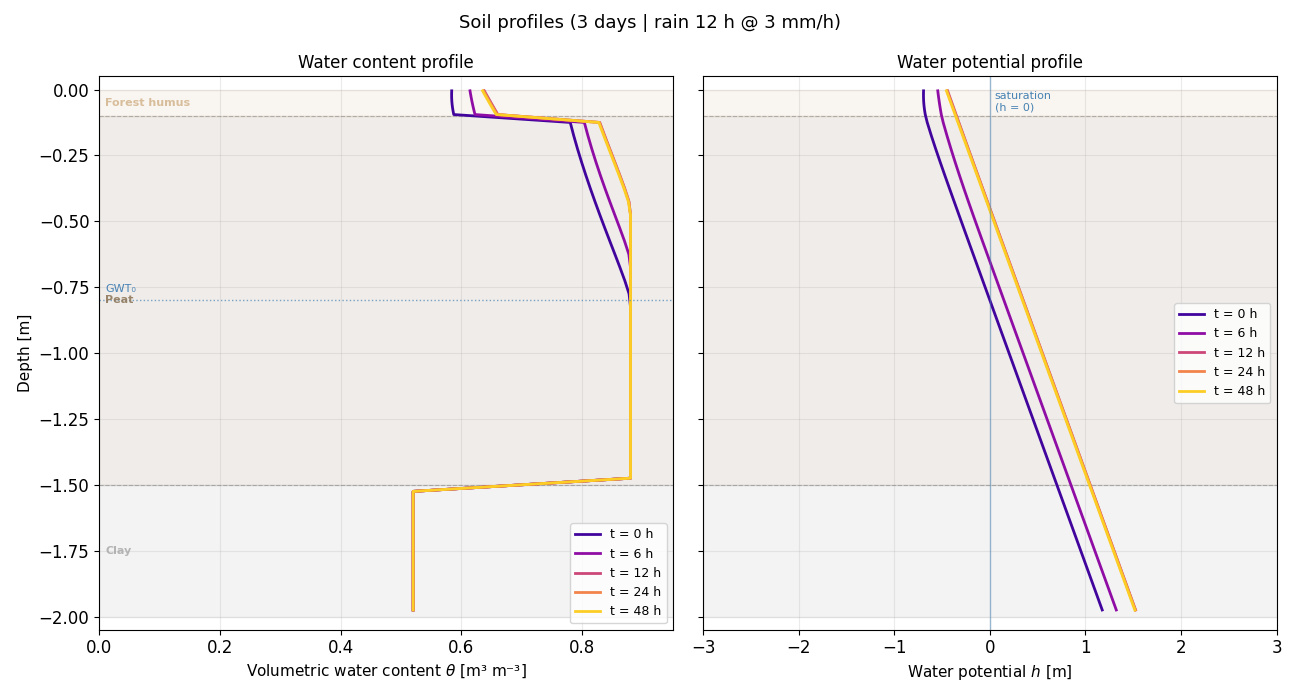

In [254]:
# Time points to visualise [h]
plot_times_h = [0, 6, 12, 24, 48, 72]
plot_times_h = [t for t in plot_times_h if t <= t_h[-1]]

cmap      = plt.cm.plasma
colors_t  = cmap(np.linspace(0.1, 0.9, len(plot_times_h)))

# Layer boundary depths and colours for background shading
layer_bounds = [0.0, zh_humus, zh_peat, zh_clay]
layer_fills  = ['#D2B48C', '#8B7355', '#A9A9A9']

def add_layer_shading(ax):
    for j in range(3):
        ax.axhspan(layer_bounds[j+1], layer_bounds[j],
                   alpha=0.13, color=layer_fills[j], zorder=0)
        if j < 2:
            ax.axhline(layer_bounds[j+1], color='gray', lw=0.8, ls='--', alpha=0.5)

fig, axes = plt.subplots(1, 2, figsize=(13, 7), sharey=True)

# ---- Left: volumetric water content ----
ax = axes[0]
add_layer_shading(ax)

for k, t_plot in enumerate(plot_times_h):
    idx = min(int(t_plot * 3600.0 / dt), n_steps - 1)
    ax.plot(SWC[idx], z, color=colors_t[k], lw=2.0, label=f't = {t_plot} h')

ax.axhline(gwl_ini, color='steelblue', lw=1.0, ls=':', alpha=0.7)
ax.text(0.01, gwl_ini + 0.03, 'GWT₀', color='steelblue', fontsize=8)

for j, lbl in enumerate(layer_names):
    ymid = (layer_bounds[j] + layer_bounds[j+1]) / 2.0
    ax.text(0.01, ymid, lbl, fontsize=8, va='center', color=layer_fills[j],
            fontweight='bold', alpha=0.85)

ax.set_xlabel('Volumetric water content $\\theta$ [m³ m⁻³]', fontsize=11)
ax.set_ylabel('Depth [m]', fontsize=11)
ax.set_title('Water content profile', fontsize=12)
ax.legend(fontsize=9, loc='lower right')
ax.set_xlim(0, 0.95); ax.set_ylim(-total_depth - 0.05, 0.05)
ax.grid(True, alpha=0.25)

# ---- Right: water potential ----
ax = axes[1]
add_layer_shading(ax)

for k, t_plot in enumerate(plot_times_h):
    idx = min(int(t_plot * 3600.0 / dt), n_steps - 1)
    ax.plot(h_prof[idx], z, color=colors_t[k], lw=2.0, label=f't = {t_plot} h')

ax.axvline(0.0, color='steelblue', lw=1.0, ls='-', alpha=0.5)
ax.text(0.05, -0.08, 'saturation\n(h = 0)', color='steelblue', fontsize=8)

ax.set_xlabel('Water potential $h$ [m]', fontsize=11)
ax.set_title('Water potential profile', fontsize=12)
ax.legend(fontsize=9, loc='center right')
ax.set_xlim(-3.0, 3.0)
ax.grid(True, alpha=0.25)

plt.suptitle(
    f'Soil profiles ({n_days} days | rain {rain_hours:.0f} h @ {rain_rate*3.6e6:.0f} mm/h)',
    fontsize=13, y=0.98)
plt.tight_layout()
# plt.show()

### 5b. Water Table and Fluxes Over Time

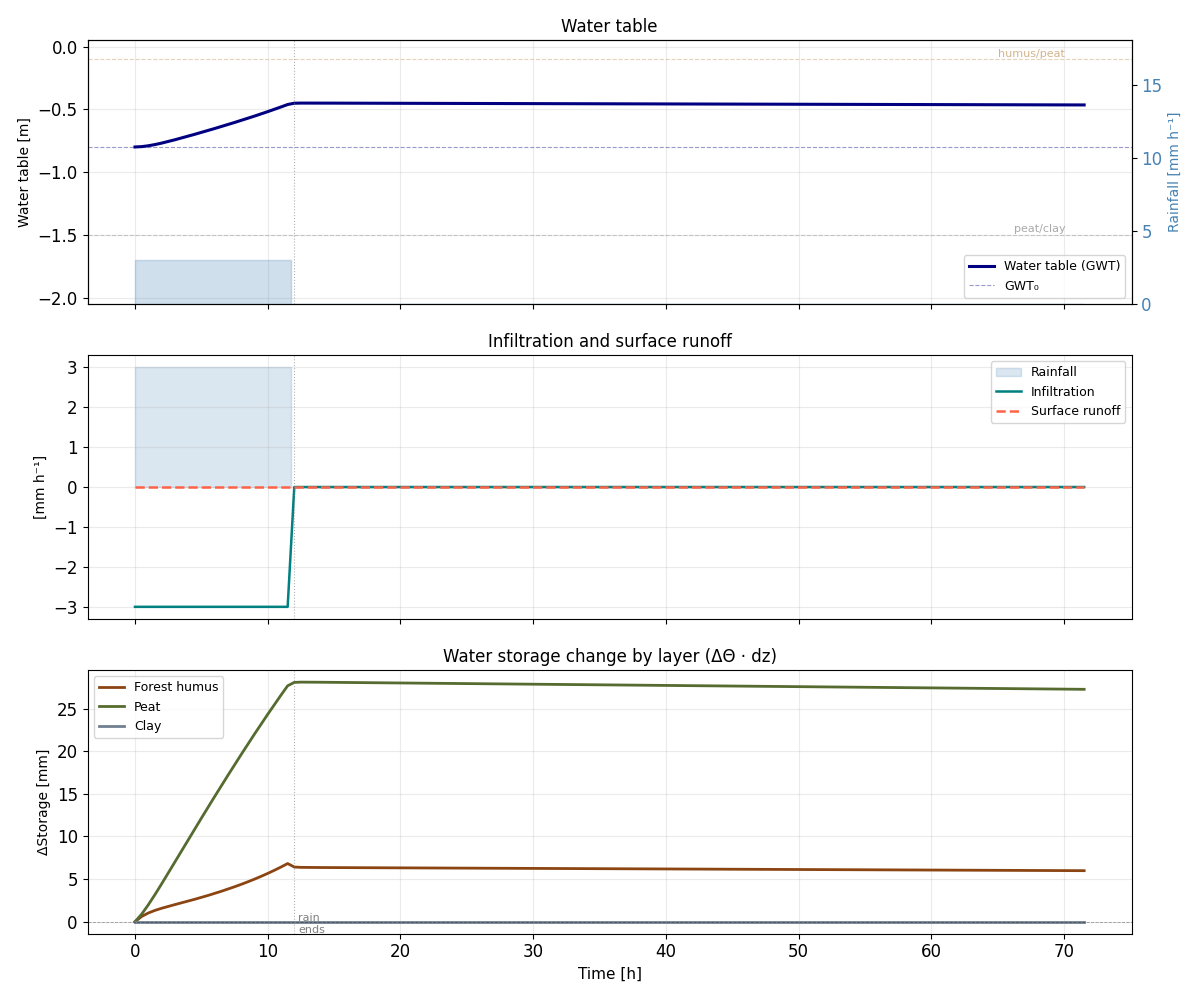

In [249]:
rain_ts_mmh = np.where(t_h < rain_hours, rain_rate * 3.6e6, 0.0)   # mm/h

# Masks for water storage by layer
ix_h = z >= zh_humus
ix_p = (z < zh_humus) & (z >= zh_peat)
ix_c = z < zh_peat

sto_h = np.array([np.sum(SWC[i, ix_h] * dz_arr[ix_h]) for i in range(n_steps)])
sto_p = np.array([np.sum(SWC[i, ix_p] * dz_arr[ix_p]) for i in range(n_steps)])
sto_c = np.array([np.sum(SWC[i, ix_c] * dz_arr[ix_c]) for i in range(n_steps)])

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# ---- (1) Water table ----
ax = axes[0]
ax_r = ax.twinx()
ax_r.fill_between(t_h, rain_ts_mmh, step='mid', alpha=0.25,
                  color='steelblue', label='Rainfall')
ax_r.set_ylabel('Rainfall [mm h⁻¹]', color='steelblue', fontsize=10)
ax_r.tick_params(axis='y', labelcolor='steelblue')
ax_r.set_ylim(0, rain_ts_mmh.max() * 6 + 0.1)

ax.plot(t_h, gwl_ts, color='navy', lw=2.2, label='Water table (GWT)')
ax.axhline(gwl_ini, color='navy', lw=0.8, ls='--', alpha=0.4, label='GWT₀')
ax.axhline(zh_humus, color=layer_fills[0], lw=0.8, ls='--', alpha=0.6)
ax.axhline(zh_peat,  color=layer_fills[2], lw=0.8, ls='--', alpha=0.6)
ax.text(t_h[-1]*0.98, zh_humus + 0.02, 'humus/peat', ha='right',
        fontsize=8, color=layer_fills[0])
ax.text(t_h[-1]*0.98, zh_peat  + 0.02, 'peat/clay',  ha='right',
        fontsize=8, color=layer_fills[2])
ax.axvline(rain_hours, color='gray', lw=0.8, ls=':', alpha=0.6)
ax.set_ylabel('Water table [m]', fontsize=10)
ax.set_title('Water table', fontsize=12)
ax.legend(loc='lower right', fontsize=9)
ax.set_ylim(-total_depth - 0.05, 0.05)
ax.grid(True, alpha=0.25)

# ---- (2) Infiltration and runoff ----
ax = axes[1]
ax.fill_between(t_h, rain_ts_mmh, alpha=0.2, color='steelblue',
                step='mid', label='Rainfall')
ax.plot(t_h, infil_ts * 3.6e6, color='teal',   lw=1.8, label='Infiltration')
ax.plot(t_h, roff_ts  * 3.6e6, color='tomato', lw=1.8, ls='--',
        label='Surface runoff')
ax.axvline(rain_hours, color='gray', lw=0.8, ls=':', alpha=0.6)
ax.set_ylabel('[mm h⁻¹]', fontsize=10)
ax.set_title('Infiltration and surface runoff', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.25)

# ---- (3) Water storage change by layer ----
ax = axes[2]
ax.plot(t_h, (sto_h - sto_h[0]) * 1000, color='#8B4513', lw=2.0,
        label='Forest humus')
ax.plot(t_h, (sto_p - sto_p[0]) * 1000, color='#556B2F', lw=2.0,
        label='Peat')
ax.plot(t_h, (sto_c - sto_c[0]) * 1000, color='#708090', lw=2.0,
        label='Clay')
ax.axhline(0, color='k', lw=0.6, ls='--', alpha=0.35)
ax.axvline(rain_hours, color='gray', lw=0.8, ls=':', alpha=0.6)
ax.text(rain_hours + 0.3, ax.get_ylim()[0] * 0.9 if ax.get_ylim()[0] < 0 else 0.5,
        'rain\nends', fontsize=8, color='gray')
ax.set_ylabel('ΔStorage [mm]', fontsize=10)
ax.set_xlabel('Time [h]', fontsize=11)
ax.set_title('Water storage change by layer (ΔΘ · dz)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.25)

plt.tight_layout()
#plt.show()

### 5c. Cumulative Water Balance

Verify that the model closes its mass balance: Rainfall = Infiltration + Surface runoff + ΔStorage.


Item                       Value [mm]
--------------------------------------
Rainfall                        36.00
Infiltration                   -36.00
Surface runoff                   0.00
Evaporation                      1.25
Pond storage                     0.00
ΔStorage                        34.75
Mass balance error         -2.125e-17


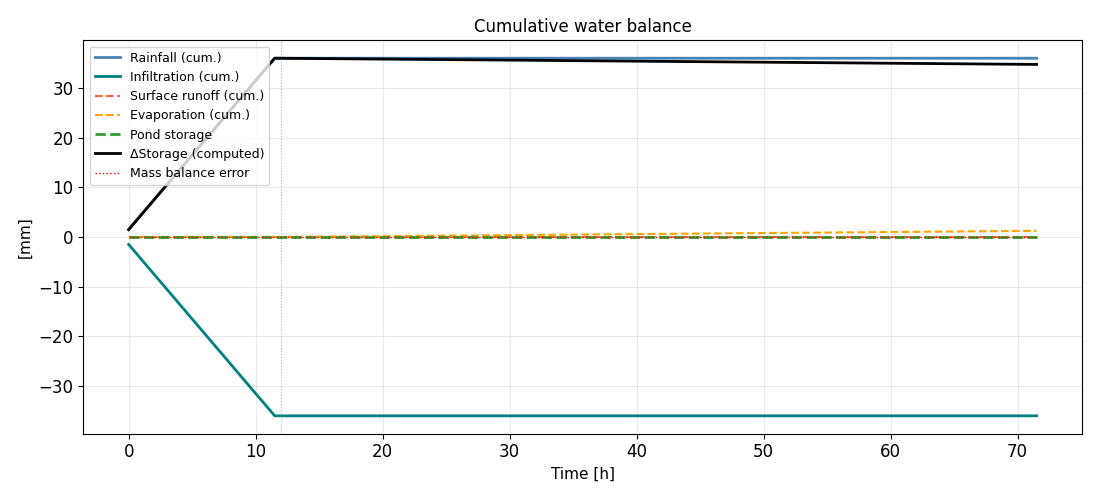

In [252]:
# Cumulative fluxes [mm]
rain_rate_ts = np.where(t_h < rain_hours, rain_rate, 0.0)
evap_rate_ts = np.where(t_h >= rain_hours, evap_rate, 0.0)

cum_rain  = np.cumsum(rain_rate_ts) * dt * 1000
cum_infil = np.cumsum(infil_ts)     * dt * 1000
cum_roff  = np.cumsum(roff_ts)      * dt * 1000
cum_evap  = np.cumsum(evap_rate_ts) * dt * 1000
pond_sto = pond_ts * 1000 # Pond storage is in meters -> convert to mm, no need to calculate cumulative storage

sto_total = np.array([np.sum(SWC[i] * dz_arr) for i in range(n_steps)])
delta_sto = (sto_total - storage_initial) * 1000   # [mm]

# Mass balance error: rain - infil - roff - delta_sto
# (evap already included in infil/roff accounting in solver)
#mbe = cum_rain - cum_infil - cum_roff - delta_sto

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(t_h, cum_rain,  color='steelblue', lw=2.0, label='Rainfall (cum.)')
ax.plot(t_h, cum_infil, color='teal',      lw=2.0, label='Infiltration (cum.)')
ax.plot(t_h, cum_roff,  color='tomato',    lw=1.5, ls='--', label='Surface runoff (cum.)')
ax.plot(t_h, cum_evap,  color='orange',    lw=1.5, ls='--', label='Evaporation (cum.)')
ax.plot(t_h, pond_sto, color='tab:green',  lw=2.0, ls='--', label='Pond storage')
ax.plot(t_h, delta_sto, color='k',         lw=2.0, label='ΔStorage (computed)')
ax.plot(t_h, mbe,       color='red',       lw=1.0, ls=':', label='Mass balance error')


ax.axvline(rain_hours, color='gray', lw=0.8, ls=':', alpha=0.6)
ax.set_xlabel('Time [h]', fontsize=11)
ax.set_ylabel('[mm]', fontsize=11)
ax.set_title('Cumulative water balance', fontsize=12)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.25)
plt.tight_layout()
#plt.show()

print(f'\n{"Item":25s}  {"Value [mm]":>10s}')
print('-' * 38)
print(f'{"Rainfall":25s}  {cum_rain[-1]:10.2f}')
print(f'{"Infiltration":25s}  {cum_infil[-1]:10.2f}')
print(f'{"Surface runoff":25s}  {cum_roff[-1]:10.2f}')
print(f'{"Evaporation":25s}  {cum_evap[-1]:10.2f}')
print(f'{"Pond storage":25s}  {pond_sto[-1]:10.2f}')
print(f'{"ΔStorage":25s}  {delta_sto[-1]:10.2f}')
print(f'{"Mass balance error":25s}  {np.sum(mbe):10.3e}')